In [1]:
import re
from bs4 import BeautifulSoup
import collections
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
soup = BeautifulSoup(open('/Users/thiberio/Pictures/yeah.html').read(), 'html.parser')

In [2]:
html = soup.prettify().split('\n')

div_blocks = []
active_block  = False
for line_num, line in enumerate(html):
    line = line.strip()
    if not line:
        continue
    
    if line == '<div class="EventSummary">':
        active_block  = True
        div_tag_count = 0
        div_start     = line_num
        continue
    
    if not active_block:
        continue
        
    if '<div' in line:
        div_tag_count += 1
    if '</div' in line:
        div_tag_count -= 1
        if not div_tag_count:
            div_end       = line_num+1
            active_block  = False
            div_blocks.append('\n'.join(html[div_start:div_end]))

In [3]:
wins   = []
draws  = []
losses = []
match_descriptions = []
for block in div_blocks:
    num_players  = int(re.search('<div class="EventPlayers">\n\s+<b>\n.+:\n\s+</b>\n\s+(\d+)', block).group(1))
    champ_format = re.search(
        '<div class="EventFormat">\n\s+<b>\n.+:\n\s+</b>\n\s+(Casual - )?(\w+)',
        block).group(2)
    
    champ_id =  re.search(
        '<div class="EventSanctionNumber">\n\s+<b>\n.+\n\s+</b>\n\s+(\S+)',
        block).group(1)
    
    matches = re.findall('''<tr class="MatchHistoryRow">([\s\S]*?)</tr>''', block)
    for match in matches:
        regex = re.search('<div class="TeamOpponent">\n\s+(.+)', match)
        if regex:
            opponent = regex.group(1)
        else:
            opponent = 'unnamed'

        if opponent == '</div>':
            opponent = 'unnamed'
        
        match_result = 'win'
        if 'Vitórias:' in match or 'Win:' in match:
            wins.append(opponent)
        elif 'Derrotas:' in match or 'Loss:' in match:
            losses.append(opponent)
            match_result = 'loss'

        else:
            draws.append(opponent)
            match_result = 'draw'

        round_num   = int(re.search('<td class="MatchPlace">\n\s+(\d+)', match).group(1))
        
        match_descriptions.append(
        [champ_format,
         pd.to_datetime('20%s' % '-'.join(champ_id.split('-')[:2]), format='%Y/%m').to_period('M'),
         champ_id,
         match_result,
         opponent]
        )
print(len(wins), len(draws), len(losses))

295 58 258


In [4]:
match_df = pd.DataFrame(columns='format date champ_id result opponent'.split(),
                  data=match_descriptions)
match_df.head()

,format,date,champ_id,result,opponent
0,Legacy,2019-06,19-06-14157483,win,Richie Corrado
1,Legacy,2019-06,19-06-14157483,win,Steven Merrill
2,Legacy,2019-06,19-06-14157483,win,Drew Reilly
3,Legacy,2019-06,19-06-14157483,loss,Ryan Schumacher
4,Legacy,2019-06,19-06-13728197,win,unnamed


In [5]:
legacy_df       = match_df[match_df.format == 'Legacy']
legacy_win_rate = sum(legacy_df.result=='win')/legacy_df.shape[0]

modern_df       = match_df[match_df.format == 'Modern']
modern_win_rate = sum(modern_df.result=='win')/modern_df.shape[0]

legacy_win_rate, modern_win_rate

(0.5182926829268293, 0.46006389776357826)

In [6]:
named_opponents = match_df[match_df.opponent != 'unnamed']
named_opponents.shape

(425, 5)

In [7]:
opponents = [opponent for opponent, num_matches in
             collections.Counter(named_opponents.opponent.tolist()).items()
            if num_matches >= 3]
named_opponents = named_opponents[named_opponents.opponent.isin(opponents)]
rivals_df = pd.DataFrame(columns='wins losses win_rate total'.split())
for opponent in opponents:
    tmp_df  = named_opponents.query('opponent==@opponent')
    results = tmp_df.result.tolist()
    num_wins = results.count('win')
    num_losses = results.count('loss')
    rivals_df.loc[opponent] = [num_wins,
                               num_losses,
                               num_wins/num_losses if num_losses > 0 else 0,
                               len(results)]

In [8]:
rivals_df.sort_values('total', ascending=False)

,wins,losses,win_rate,total
Grant Fishman,4.0,5.0,0.800000,10.0
Jorge Klotz,4.0,2.0,2.000000,8.0
Diogo Tamashiro,6.0,2.0,3.000000,8.0
Richie Corrado,6.0,1.0,6.000000,7.0
Wellington Carneiro,5.0,2.0,2.500000,7.0
Daniel Silva,1.0,4.0,0.250000,6.0
Zach Vanderzee,3.0,2.0,1.500000,6.0
Jordan Munson,4.0,2.0,2.000000,6.0
Max Pohlman,1.0,2.0,0.500000,5.0
Daniel Coelho,4.0,0.0,0.000000,4.0


In [9]:
rivals_df.sum()

wins         71.000000
losses       66.000000
win_rate     42.716667
total       145.000000
dtype: float64

In [10]:
temporal_df = pd.DataFrame(columns='matches_played win_rate date date_proportion'.split())
newest_champ = match_df.date.max()
for month in match_df.date.unique():
    tmp_df     = match_df.query('date==@month')
    results    = tmp_df.result.tolist()
    num_wins   = results.count('win')
    num_losses = results.count('loss')
    temporal_df.loc[month] = [len(results),
                              num_wins/(num_wins+num_losses),
                              month,
                              newest_champ-month]

temporal_df.sort_values('date_proportion', ascending=False, inplace=True)
#temporal_df = temporal_df[temporal_df.date > pd.to_datetime('2010-01', format='%Y/%m').to_period('M')]
temporal_df.head()

,matches_played,win_rate,date,date_proportion
2004-04,7,0.666667,2004-04,182
2005-03,6,0.400000,2005-03,171
2005-05,7,0.600000,2005-05,169
2006-04,7,0.833333,2006-04,158
2006-06,8,1.000000,2006-06,156


<bound method Figure.tight_layout of <Figure size 6000x1500 with 1 Axes>>

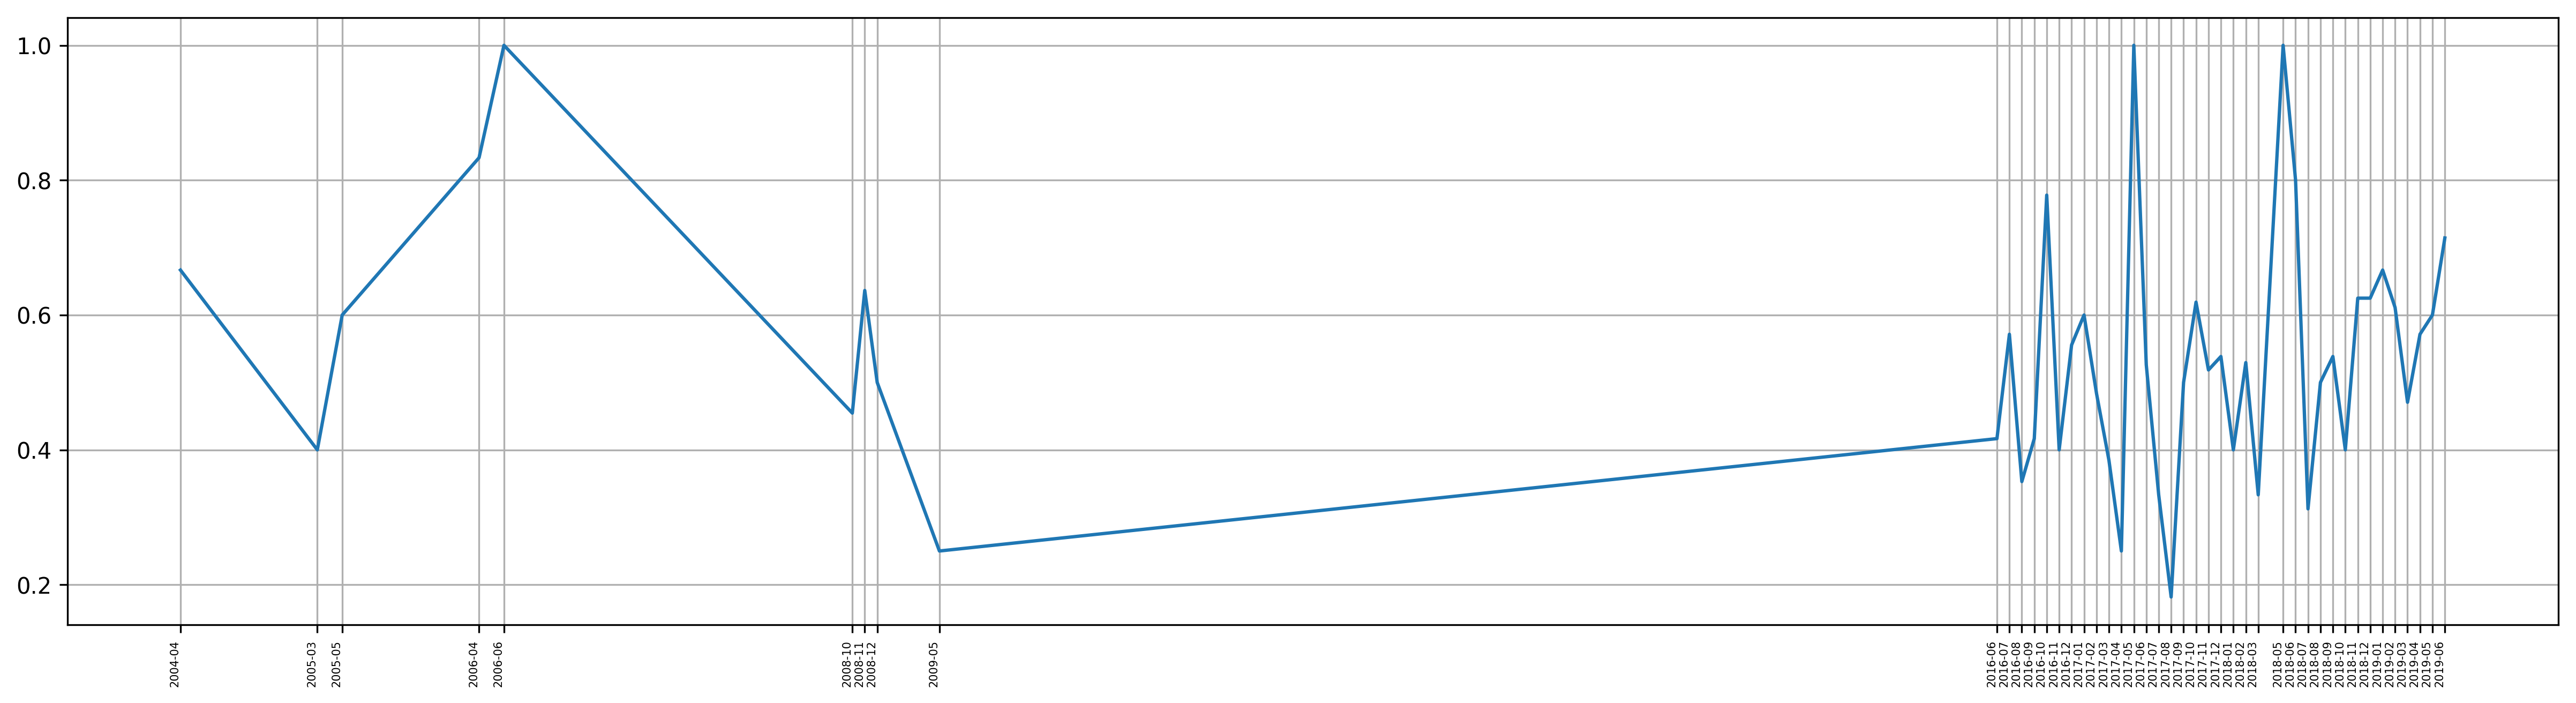

In [11]:
fig, ax = plt.subplots(figsize=(20,5), dpi=300)
ax.plot(temporal_df.date_proportion.tolist(), temporal_df.win_rate.tolist())
xlims = list(ax.get_xlim())
xlims.reverse()
plt.xlim(xlims)
ax.set_xticks(temporal_df.date_proportion.tolist())
rotate_xlabel = ax.set_xticklabels(temporal_df.date.tolist(), rotation=90, ha='right', fontsize=5)
ax.grid()
fig.tight_layout

<bound method Figure.tight_layout of <Figure size 6000x1500 with 2 Axes>>

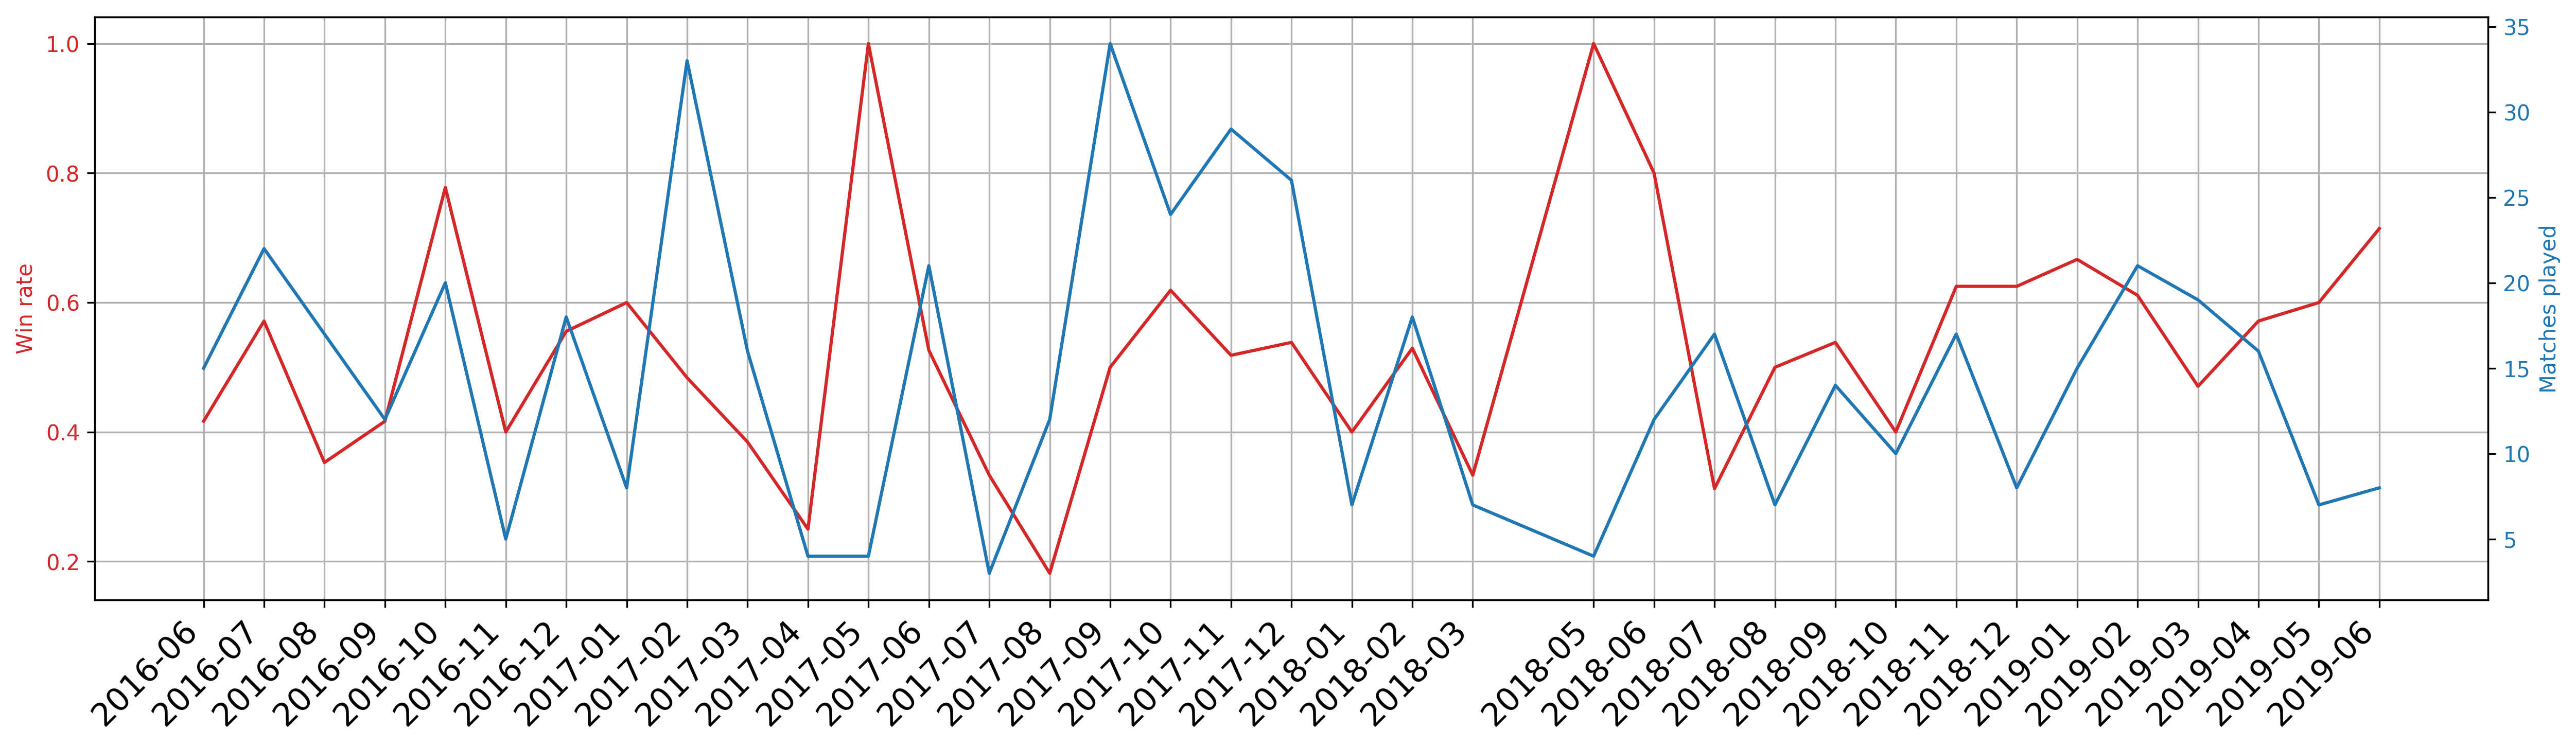

In [12]:
tmp = temporal_df[temporal_df.date > pd.to_datetime('2010-01', format='%Y/%m').to_period('M')]

fig, ax = plt.subplots(figsize=(20,5), dpi=300)
                       
color = 'tab:red'
ax.plot(tmp.date_proportion.tolist(), tmp.win_rate.tolist(), color=color)
ax.set_ylabel('Win rate', color=color)
ax.tick_params(axis='y', labelcolor=color)

color = 'tab:blue'
ax_twin = ax.twinx()
ax_twin.plot(tmp.date_proportion.tolist(), tmp.matches_played.tolist(), color=color)
ax_twin.set_ylabel('Matches played', color=color)
ax_twin.tick_params(axis='y', labelcolor=color)

xlims = list(ax.get_xlim())
xlims.reverse()
plt.xlim(xlims)
ax.set_xticks(tmp.date_proportion.tolist())
rotate_xlabel = ax.set_xticklabels(tmp.date.tolist(), rotation=45, ha='right', fontsize=15)
ax.grid()
fig.tight_layout

((-0.08254374042963915, 0.589845581506907),
 SpearmanrResult(correlation=0.03869696949492867, pvalue=0.800749822866903))

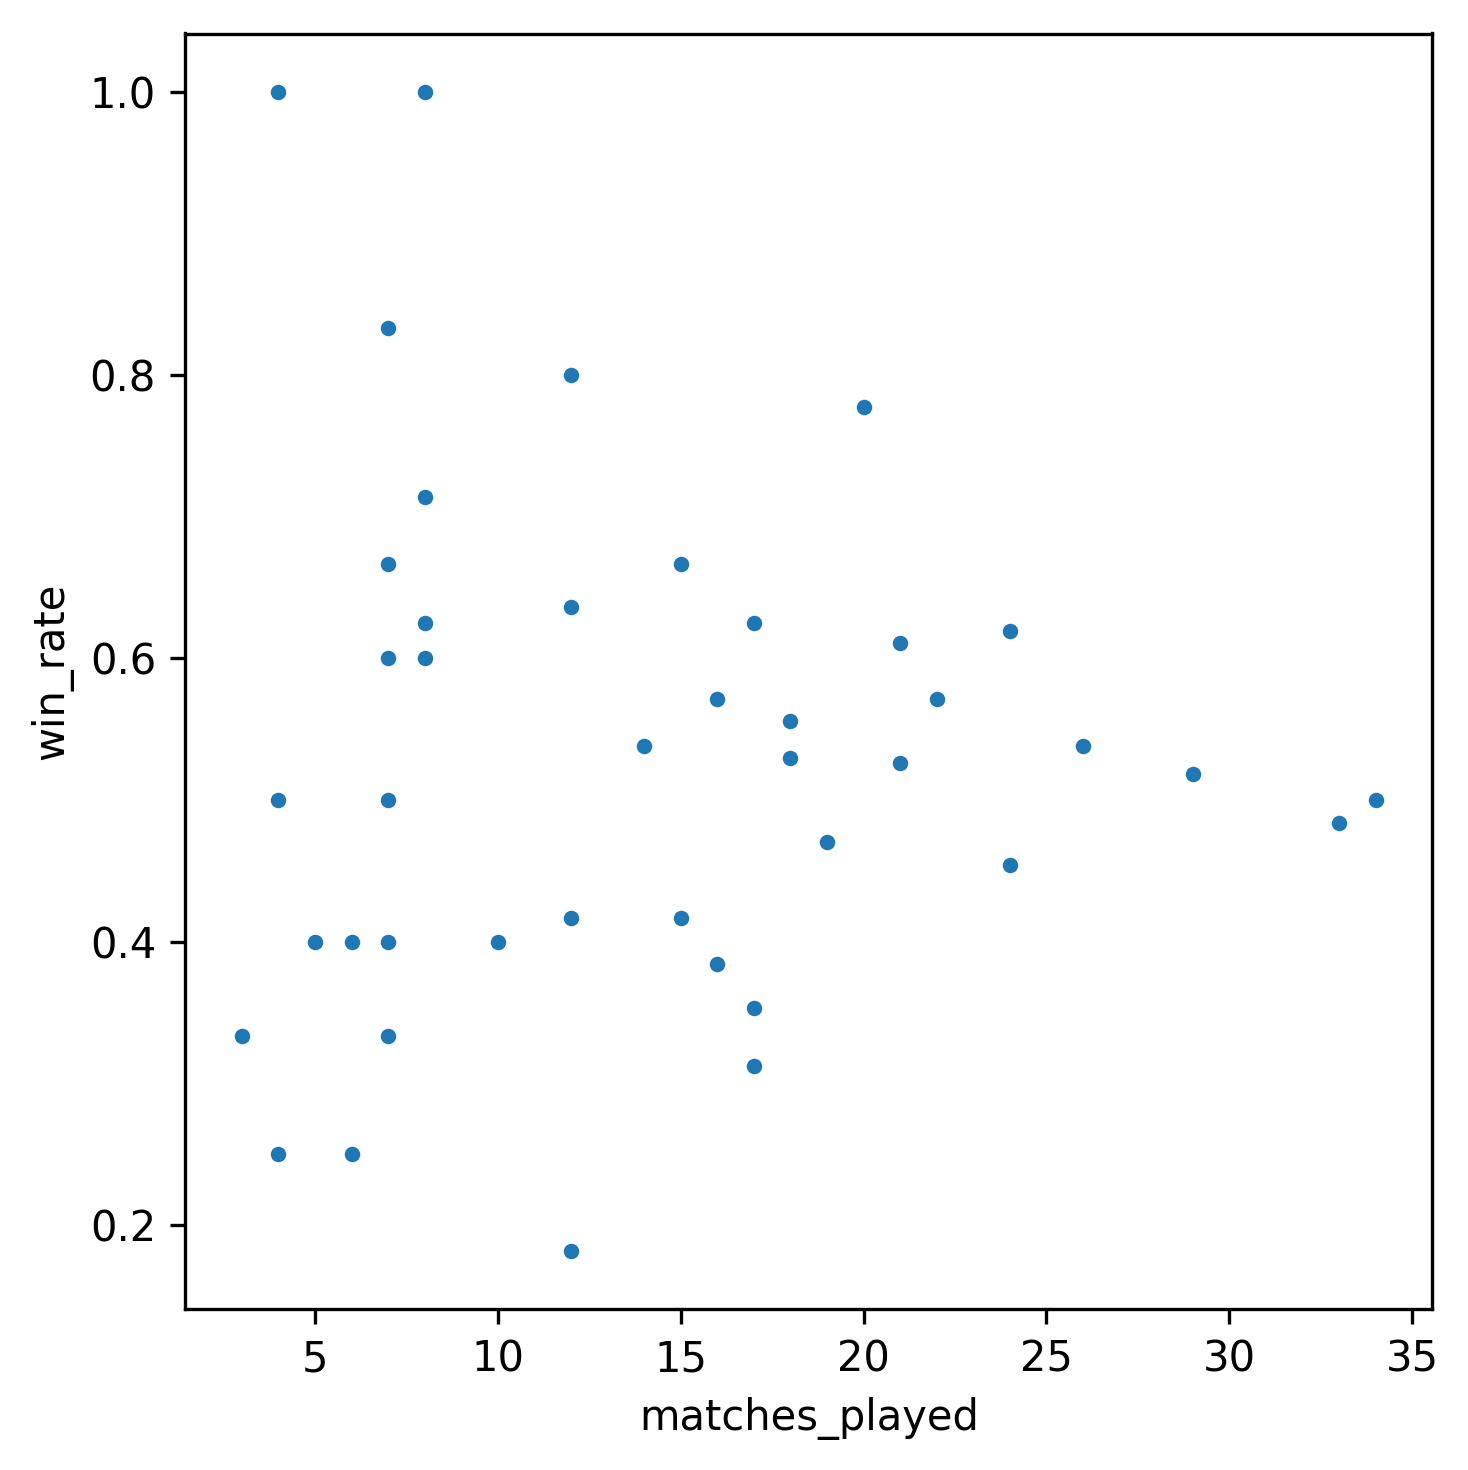

In [13]:
fig, ax = plt.subplots(figsize=(5,5), dpi=300)
sns.scatterplot('matches_played', 'win_rate', data=temporal_df, edgecolor='w', s=20)
fig.tight_layout()
pearsonr(temporal_df.matches_played.tolist(),
         temporal_df.win_rate.tolist()
        ),spearmanr(temporal_df.matches_played.tolist(),
                    temporal_df.win_rate.tolist())